In [29]:
import pandas as pd
import matplotlib.pyplot as plt

# Extracting data from [US Environmental Protection Agency](https://aqs.epa.gov/aqsweb/airdata/download_files.html)

The following code downloads every single `.zip` file from the Annual Summary Data table, specifically the AQI by County column. Then the `.csv` files are extracted and concatenated into a single pandas dataframe. The resulting dataframe, `final_df` is converted into `combined_aqi_by_county.csv` and saved to drive.

Getting the file from Drive is faster than doing this entire process everytime a new runtime connection has to be made.

(Last run: May 7th, 2025)

```
import os
import zipfile
import shutil

# Create directories for zipped and extracted data if they don't exist
os.makedirs('/content/zipped', exist_ok=True)
os.makedirs('/content/extracted_data', exist_ok=True)

# Download all ZIP files for 2024 to 1980 into the 'zipped' folder
base_url = 'https://aqs.epa.gov/aqsweb/airdata/annual_aqi_by_county_{}.zip'

for year in range(2024, 1979, -1):  # Download files from 2024 to 1980
    zip_file_name = os.path.join('/content/zipped', f'annual_aqi_by_county_{year}.zip')  # Save as annual_aqi_by_county_YEAR.zip
    download_url = base_url.format(year)
    print(f"Downloading {download_url}...")
    !wget -O {zip_file_name} {download_url}

# Unzip each downloaded file into 'extracted_data'
for zip_file in os.listdir('/content/zipped'):
    zip_file_path = os.path.join('/content/zipped', zip_file)
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall('/content/extracted_data')

# Delete the 'zipped' folder and its contents after extraction
shutil.rmtree('/content/zipped')
shutil.rmtree('/content/sample_data')

# Verify extraction
!ls /content/extracted_data

# Initialize an empty list to hold individual DataFrames
df_list = []

# Read all CSV files from the extracted data and combine them into a single DataFrame
for file in os.listdir('/content/extracted_data'):
    if file.endswith('.csv'):  # Only process CSV files
        file_path = os.path.join('/content/extracted_data', file)
        print(f"Reading {file_path}...")
        df = pd.read_csv(file_path)  # Read each CSV file into a DataFrame
        df_list.append(df)  # Add the DataFrame to the list

# Concatenate all DataFrames into a single DataFrame
final_df = pd.concat(df_list, ignore_index=True)

# Display the first few rows of the combined DataFrame
final_df.head()

# Save the DataFrame to a CSV file
final_df.to_csv('/content/combined_aqi_by_county.csv', index=False)

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Define the path inside your Google Drive
output_path = '/content/drive/My Drive/Colab Notebooks/Datasets, spreadsheets, etc.'

# Create the folder if it doesn't exist
os.makedirs(output_path, exist_ok=True)

# Save the DataFrame to that path
final_df.to_csv(f'{output_path}/combined_aqi_by_county.csv', index=False)

## (Optional) Download the CSV file
# from google.colab import files
# files.download('/content/combined_aqi_by_county.csv')
```

# Getting the data

In [13]:
# Easy simple way of accessing my datasets
aqi_df_sharelink = 'https://drive.google.com/file/d/130DVMpCfi1dujuygMyI8bzoP1fvSONvO/view?usp=drive_link' # this is the link received when clicked the Share button in Google Drive
aqi_df = pd.read_csv('https://drive.google.com/uc?export=download&id='+aqi_df_sharelink.split('/d/')[1].split('/')[0]) # this parses the string from the line above to make a download link

aqi_df = aqi_df[aqi_df['State'] != 'Country Of Mexico'].copy() # dropping Mexico from the analysis

In [14]:
#aqi_df[(aqi_df['Hazardous Days'] + 5) >= aqi_df['Days with AQI']]

In [15]:
#aqi_df = aqi_df[aqi_df['Days with AQI'] >= (365 * 2 / 3)]

#aqi_df

| **Column**                              | **Description**                                                                                                                                                                                    |
| --------------------------------------- | -------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| **Days with AQI**                       | Total number of days in the year for which the Air Quality Index (AQI) was calculated.                                                                                                             |
| **Good Days**                           | Number of days the AQI was in the "Good" range (0–50), meaning air quality was satisfactory with little or no risk.                                                                                |
| **Moderate Days**                       | Number of days the AQI was in the "Moderate" range (51–100), which may pose a minor risk to a very small number of sensitive individuals.                                                          |
| **Unhealthy for Sensitive Groups Days** | Days when AQI was in the 101–150 range, where sensitive individuals (e.g., elderly, children, those with asthma) may experience health effects, but the general public is unlikely to be affected. |
| **Unhealthy Days**                      | Days with AQI in the 151–200 range. Everyone may begin to experience health effects, and members of sensitive groups may experience more serious effects.                                          |
| **Very Unhealthy Days**                 | Days with AQI between 201–300. Health alert: everyone may experience more serious health effects.                                                                                                  |
| **Hazardous Days**                      | Days with AQI above 300. Health warnings of emergency conditions: the entire population is more likely to be affected.                                                                             |
| **Max AQI**                             | The highest (worst) AQI value recorded for the county during the year.                                                                                                                             |
| **90th Percentile AQI**                 | The AQI value below which 90% of the daily AQI values fall. This gives an idea of how bad AQI gets on the worse days, without considering extremes.                                                |
| **Median AQI**                          | The middle AQI value for the year—half of the AQI values were above this, and half were below.                                                                                                     |
| **Days CO**                             | Number of days where carbon monoxide (CO) was the primary pollutant determining the AQI.                                                                                                           |
| **Days NO2**                            | Number of days where nitrogen dioxide (NO₂) was the primary pollutant determining the AQI.                                                                                                         |
| **Days Ozone**                          | Number of days where ground-level ozone was the dominant pollutant affecting the AQI.                                                                                                              |
| **Days PM2.5**                          | Number of days where fine particulate matter (PM2.5) was the primary pollutant.                                                                                                                    |
| **Days PM10**                           | Number of days where coarse particulate matter (PM10) was the primary pollutant.                                                                                                                   |


# Analyzing the data

In [16]:
# aqi_df.groupby('State').apply(lambda x: (x['Hazardous Days'] > 0).sum(), include_groups=False) \
#     .reset_index(name='Hazardous Days Count Above Threshold') \
#     .sort_values(by='Hazardous Days Count Above Threshold', ascending=False) \
#     .head(5)

In [17]:
# aqi_df.groupby('State').apply(lambda x: (x['Very Unhealthy Days'] > 0).sum(), include_groups=False) \
#     .reset_index(name='Hazardous Days Count Above Threshold') \
#     .sort_values(by='Hazardous Days Count Above Threshold', ascending=False) \
#     .head(5)

In [18]:
# days_per_aqi = aqi_df.copy()

# for i in ['Good Days','Moderate Days','Unhealthy for Sensitive Groups Days','Unhealthy Days','Very Unhealthy Days','Hazardous Days']:
#     days_per_aqi[i] = (days_per_aqi[i]/days_per_aqi['Days with AQI'])*100

# days_per_aqi.head()

# --------------------------------------------------------------------------------------------------------------------------------------------


# for i in ['Good Days','Moderate Days','Unhealthy for Sensitive Groups Days','Unhealthy Days','Very Unhealthy Days','Hazardous Days']:
#     aqi_df[i] = (aqi_df[i] * aqi_df['Days with AQI']).sum() / aqi_df['Days with AQI'].sum() # weighted days to balance years with low value days with AQI

# aqi_df.head()

,State,County,Year,Days with AQI,Good Days,Moderate Days,Unhealthy for Sensitive Groups Days,Unhealthy Days,Very Unhealthy Days,Hazardous Days,Max AQI,90th Percentile AQI,Median AQI,Days CO,Days NO2,Days Ozone,Days PM2.5,Days PM10
0,Alabama,Baldwin,2001,283,174.0,95.0,12.0,2.0,0.0,0.0,159,84,46,0,0,203,80,0
1,Alabama,Clay,2001,279,145.0,119.0,14.0,1.0,0.0,0.0,164,87,49,0,0,197,82,0
2,Alabama,Colbert,2001,100,36.0,64.0,0.0,0.0,0.0,0.0,90,78,55,0,0,0,100,0
3,Alabama,DeKalb,2001,365,198.0,136.0,28.0,3.0,0.0,0.0,164,97,47,0,0,292,73,0
4,Alabama,Elmore,2001,241,165.0,63.0,12.0,1.0,0.0,0.0,154,80,43,0,0,241,0,0


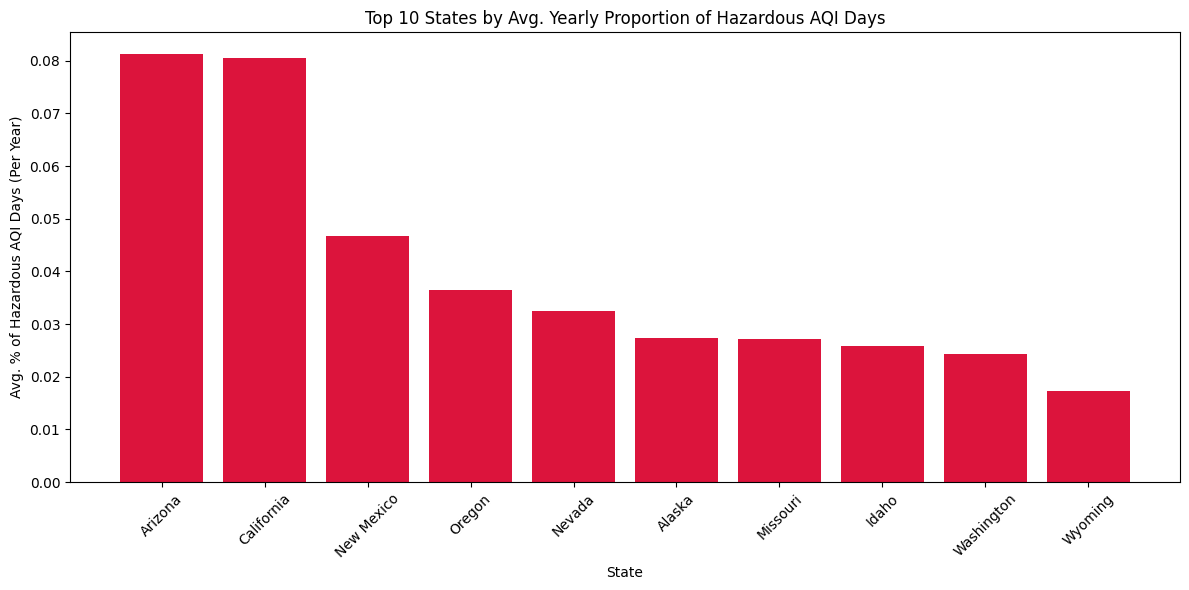

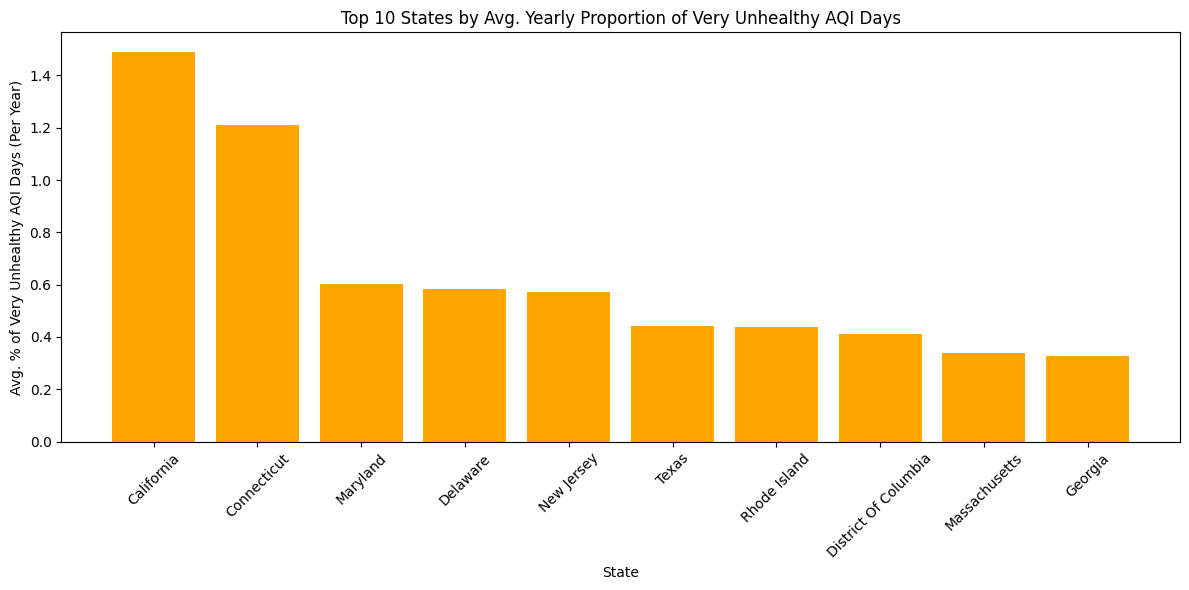

In [30]:
# Step 2: Group by State and Year, calculate per-year proportions
yearly = aqi_df.groupby(['State', 'Year']).apply(
    lambda x: pd.Series({
        'Yearly Hazardous Proportion': x['Hazardous Days'].sum() / x['Days with AQI'].sum(),
        'Yearly Very Unhealthy Proportion': x['Very Unhealthy Days'].sum() / x['Days with AQI'].sum()
    }),
    include_groups=False
).reset_index()

# Step 3: Now average across years per state
state_avg = yearly.groupby('State').mean().reset_index()

# Step 4: Plot top 10 states by average yearly hazardous proportion
top10_hazardous = state_avg.sort_values(by='Yearly Hazardous Proportion', ascending=False).head(10)

plt.figure(figsize=(12, 6))
plt.bar(top10_hazardous['State'], top10_hazardous['Yearly Hazardous Proportion'] * 100, color='crimson')
plt.xlabel('State')
plt.ylabel('Avg. % of Hazardous AQI Days (Per Year)')
plt.title('Top 10 States by Avg. Yearly Proportion of Hazardous AQI Days')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Top 10 states by avg. yearly Very Unhealthy proportion
top10_unhealthy = state_avg.sort_values(by='Yearly Very Unhealthy Proportion', ascending=False).head(10)

plt.figure(figsize=(12, 6))
plt.bar(top10_unhealthy['State'], top10_unhealthy['Yearly Very Unhealthy Proportion'] * 100, color='orange')
plt.xlabel('State')
plt.ylabel('Avg. % of Very Unhealthy AQI Days (Per Year)')
plt.title('Top 10 States by Avg. Yearly Proportion of Very Unhealthy AQI Days')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

California has a lot more hazardous days than any other state.

In [20]:
nocounty_df = aqi_df.drop(columns=['County'])
grouped_year_state_df = nocounty_df.groupby(['Year', 'State']).mean().reset_index()
avg_byyear_bystate = grouped_year_state_df.drop(columns='State').groupby('Year').mean().reset_index()
avg_byyear_bystate.head()

,Year,Days with AQI,Good Days,Moderate Days,Unhealthy for Sensitive Groups Days,Unhealthy Days,Very Unhealthy Days,Hazardous Days,Max AQI,90th Percentile AQI,Median AQI,Days CO,Days NO2,Days Ozone,Days PM2.5,Days PM10
0,1980,299.292102,196.920982,70.723994,20.764759,7.844827,3.034661,0.002878,178.511641,94.483729,41.751459,89.758457,45.396951,164.136694,0.0,0.000000
1,1981,300.273510,207.071517,71.442183,15.462899,4.694097,1.598813,0.004000,164.396693,80.406775,39.297182,92.743874,44.020457,163.509178,0.0,0.000000
2,1982,303.173787,211.380910,71.573567,14.074951,4.558381,1.580977,0.005000,167.127825,79.726026,39.590684,99.467069,40.090273,163.575483,0.0,0.040962
3,1983,304.236726,207.290884,68.946352,17.442222,7.566775,2.988494,0.002000,174.539412,92.852130,40.419898,94.223949,37.797278,171.223620,0.0,0.991879
4,1984,302.200240,210.542912,69.698523,15.661737,4.773262,1.523806,0.000000,162.721590,82.457430,38.981577,88.343071,43.704390,166.364649,0.0,3.788130


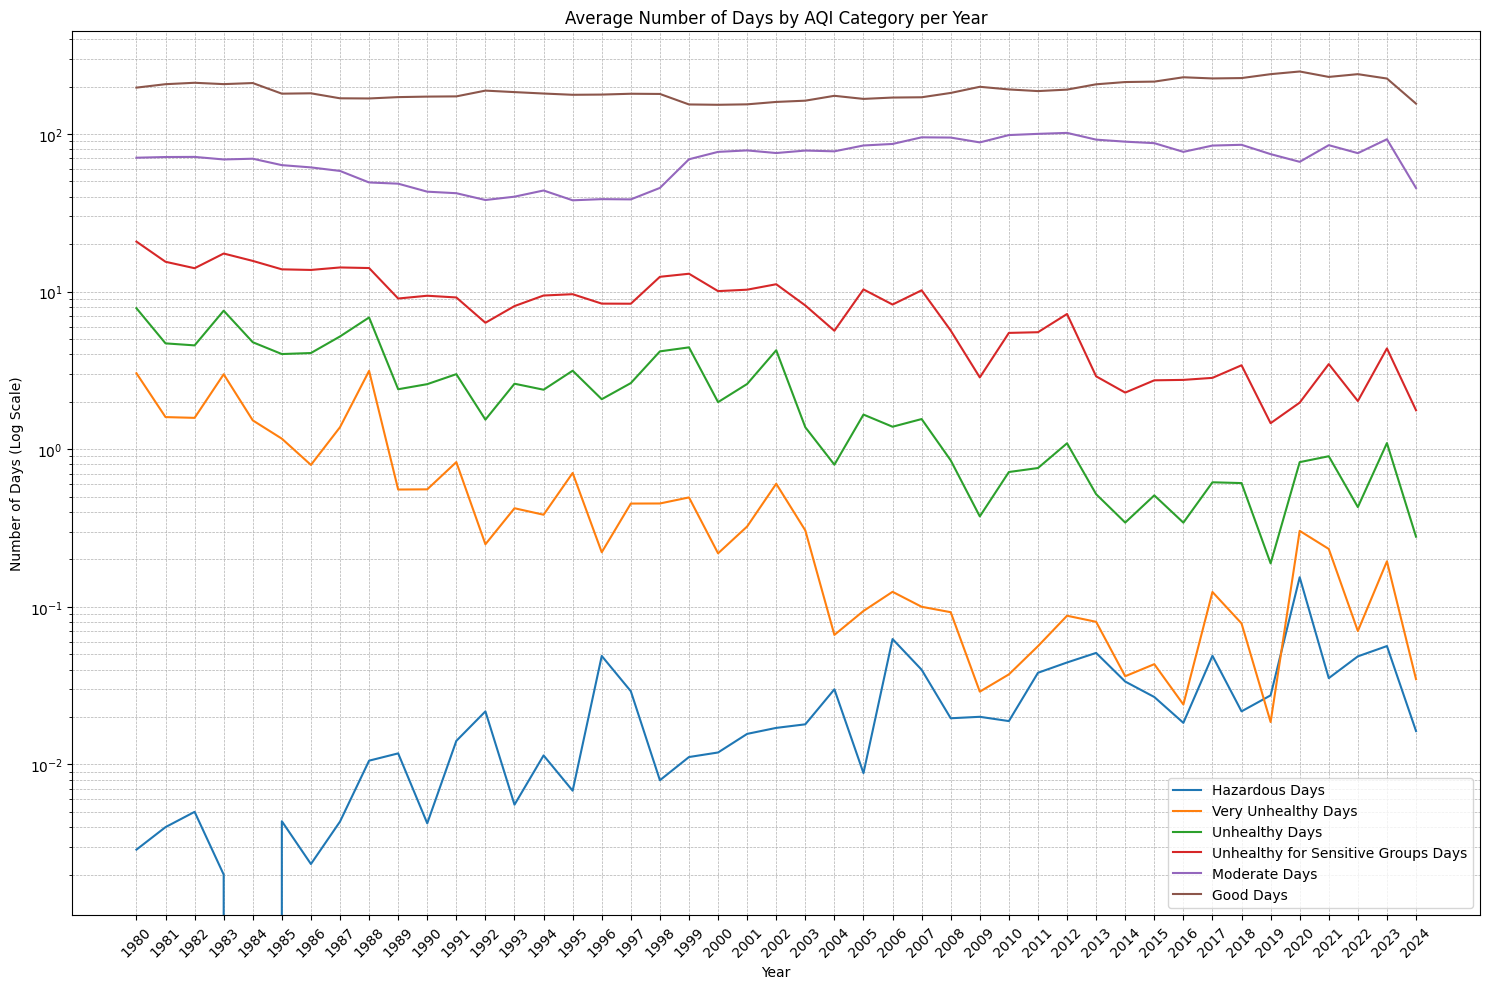

In [21]:
import matplotlib.pyplot as plt

# Create the plot
plt.figure(figsize=(15, 10))

plt.plot(avg_byyear_bystate['Year'], avg_byyear_bystate['Hazardous Days'], label='Hazardous Days')
plt.plot(avg_byyear_bystate['Year'], avg_byyear_bystate['Very Unhealthy Days'], label='Very Unhealthy Days')
plt.plot(avg_byyear_bystate['Year'], avg_byyear_bystate['Unhealthy Days'], label='Unhealthy Days')
plt.plot(avg_byyear_bystate['Year'], avg_byyear_bystate['Unhealthy for Sensitive Groups Days'], label='Unhealthy for Sensitive Groups Days')
plt.plot(avg_byyear_bystate['Year'], avg_byyear_bystate['Moderate Days'], label='Moderate Days')
plt.plot(avg_byyear_bystate['Year'], avg_byyear_bystate['Good Days'], label='Good Days')

plt.yscale('log')  # for better visualization
plt.xlabel('Year')
plt.ylabel('Number of Days (Log Scale)')
plt.title('Average Number of Days by AQI Category per Year')
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.xticks(avg_byyear_bystate['Year'], rotation=45)
plt.tight_layout()
plt.show()